In [1]:
import os
os.chdir("C:/Users/MaxT/Desktop/Internet Explorer/max/BOOST!/State")

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import word_tokenize,sent_tokenize
import wordninja

from pathlib import Path
np.random.seed(2018)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\MaxT\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Text Cleaning

In [3]:
txt = Path('Buchanan_1857.txt').read_text()
txt = txt.replace('\n','')

In [4]:
txt[:900]

'Fellow-Citizens of the Senate and House of Representatives:In obedience to the command of the Constitution, it has now become my duty"to give to Congress information of the state of the Union and recommend totheir consideration such measures" as I judge to be "necessary andexpedient."But first and above all, our thanks are due to Almighty God for thenumerous benefits which He has bestowed upon this people, and our unitedprayers ought to ascend to Him that He would continue to bless our greatRepublic in time to come as He has blessed it in time past. Since theadjournment of the last Congress our constituents have enjoyed an unusualdegree of health. The earth has yielded her fruits abundantly and hasbountifully rewarded the toil of the husbandman. Our great staples havecommanded high prices, and up till within a brief period our manufacturing,mineral, and mechanical occupations have largel'

##### Note : This address contains a lot of concatenated word (ex : thenumerous, greatRebuplic, unusualdegree, etc)

In [5]:
kalimat_txt = sent_tokenize(txt) #tokenize into sentences
kalimat_txt[1]

'"But first and above all, our thanks are due to Almighty God for thenumerous benefits which He has bestowed upon this people, and our unitedprayers ought to ascend to Him that He would continue to bless our greatRepublic in time to come as He has blessed it in time past.'

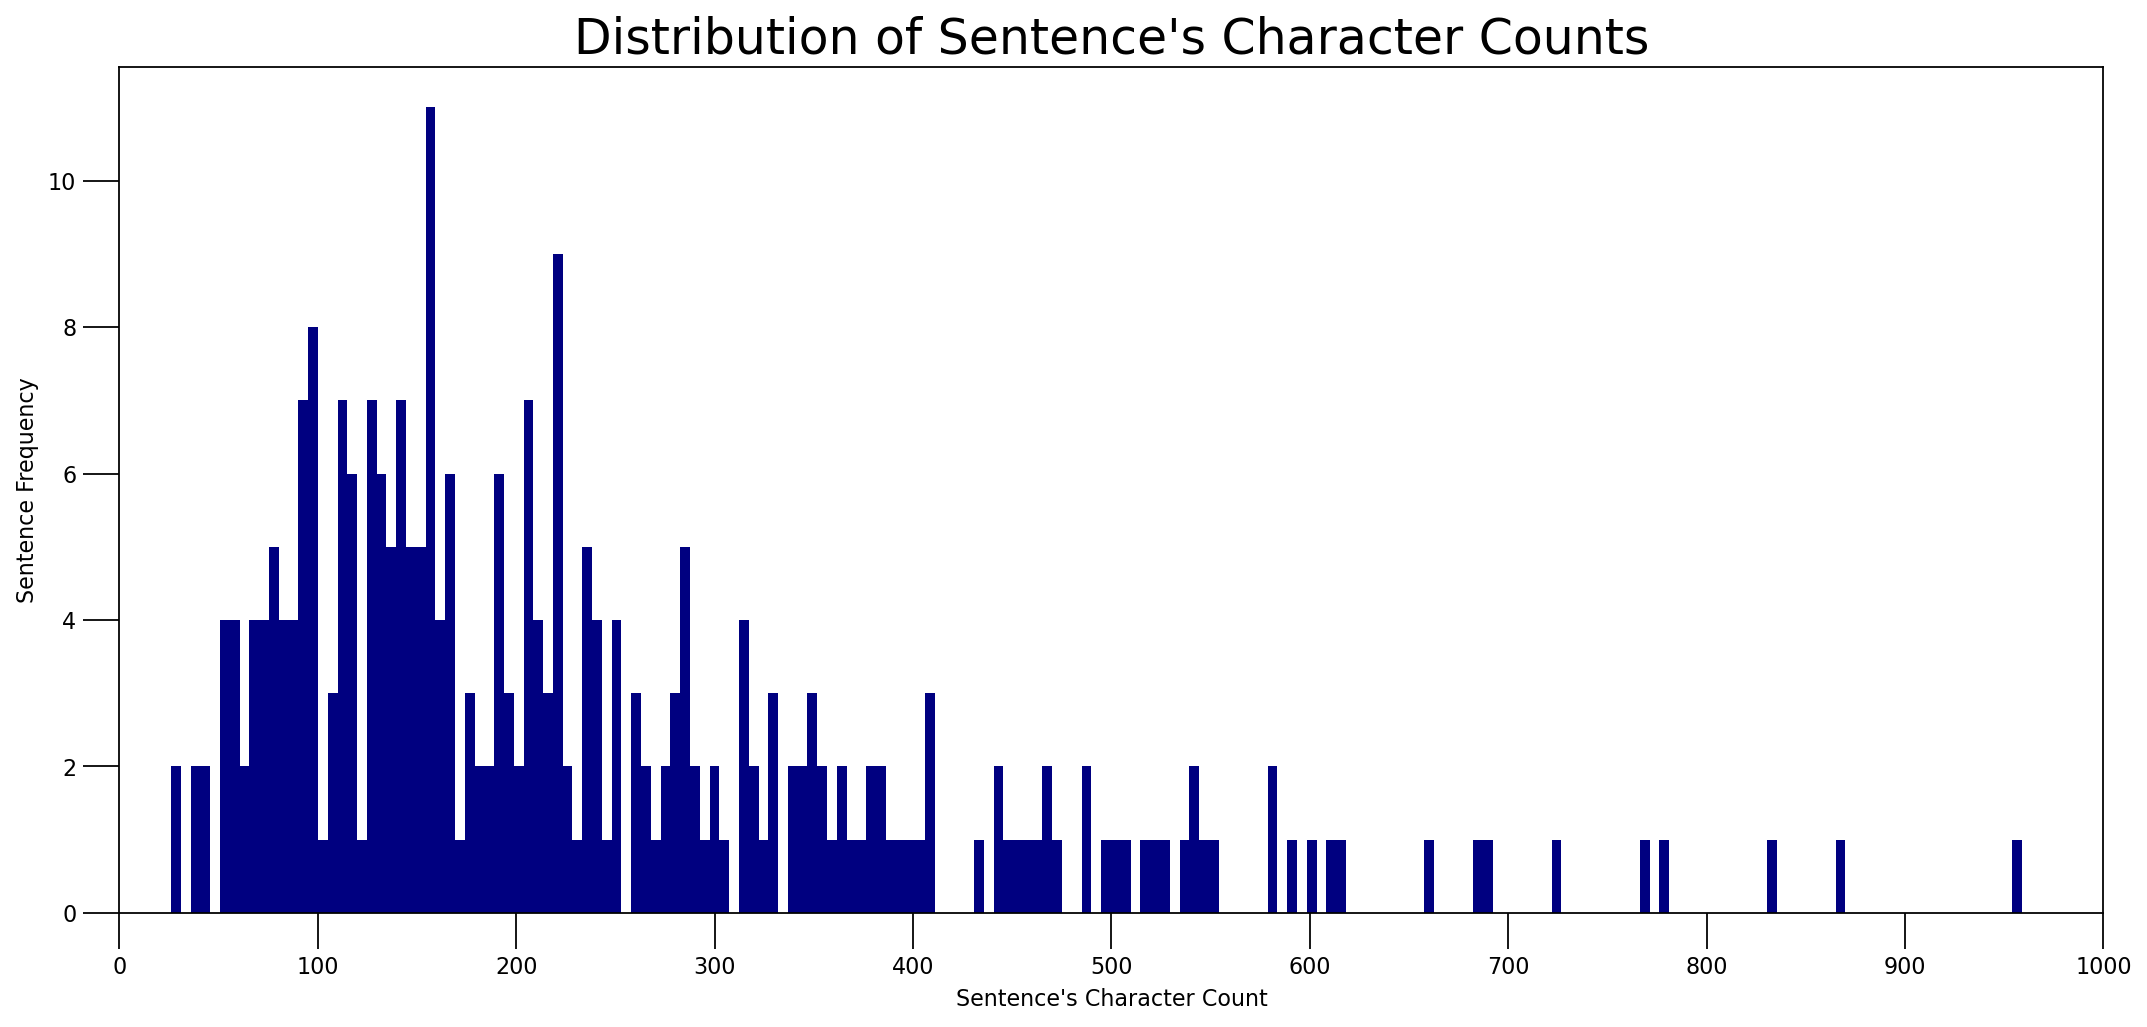

In [14]:
#plot the distribution of sentence's character counts
doc_lens = [sum(len(x) for x in d.split()) for d in kalimat_txt]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 200, color='navy')

plt.gca().set(xlim=(0, 1000), ylabel='Sentence Frequency', xlabel="Sentence's Character Count")
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,11))
plt.title("Distribution of Sentence's Character Counts", fontdict=dict(size=22))
plt.show()

In [12]:
print('Mean of character count/sentence :', sum(doc_lens)/len(doc_lens))

Mean of character count/sentence : 242.91814946619218


#### As mentioned before, this address contains a lot af concatenated word. Therefore, we use wordninja to tokenize and also split concatenated word. Then, WordNetLemmatizer is applied to tokenized word if defined conditions is satisfied. We also lowercase all the word to avoid duplicated unique word.

In [7]:
def clean_text(headline):
    le=WordNetLemmatizer()
    tokens= [[le.lemmatize(word) for word in wordninja.split(s) if word not in STOPWORDS and len(word)>3] for s in headline]
    lower = [[word.lower() for word in ss] for ss in tokens]
    return lower

In [8]:
lema_kal_txt1 = clean_text(kalimat_txt)

## TF-IDF

In [9]:
dictionary=gensim.corpora.Dictionary(lema_kal_txt1)
dictionary.filter_extremes(no_below=8,no_above=0.7,keep_n=1000)

In [10]:
print(dictionary)

Dictionary(123 unique tokens: ['congress', 'consideration', 'constitution', 'duty', 'necessary']...)


In [11]:
bow_corpus=[dictionary.doc2bow(doc) for doc in lema_kal_txt1]   #bag-of-word

In [12]:
tfidf = models.TfidfModel(bow_corpus)  #increase the weight

In [13]:
corpus_tfidf = tfidf[bow_corpus]    

## LDA - Hyperparameter tuning

In [14]:
#train model with different number of topic
index1 = [2,3,6,8,9,10]
lda_model_2=gensim.models.LdaMulticore(corpus_tfidf,num_topics=index1[0],id2word=dictionary,passes=2,workers=4,random_state=7)
lda_model_3=gensim.models.LdaMulticore(corpus_tfidf,num_topics=index1[1],id2word=dictionary,passes=2,workers=4,random_state=7)
lda_model_6=gensim.models.LdaMulticore(corpus_tfidf,num_topics=index1[2],id2word=dictionary,passes=2,workers=4,random_state=7)
lda_model_8=gensim.models.LdaMulticore(corpus_tfidf,num_topics=index1[3],id2word=dictionary,passes=2,workers=4,random_state=7)
lda_model_9=gensim.models.LdaMulticore(corpus_tfidf,num_topics=index1[4],id2word=dictionary,passes=2,workers=4,random_state=7)
lda_model_10=gensim.models.LdaMulticore(corpus_tfidf,num_topics=index1[5],id2word=dictionary,passes=2,workers=4,random_state=7)

In [27]:
#evaluate using the coherence score and perplexity
ldamodel1 = [lda_model_2,lda_model_3,lda_model_6,lda_model_8,lda_model_9,lda_model_10]

for i in range(len(ldamodel1)):
    coherence_model_lda=CoherenceModel(model=ldamodel1[i],texts=lema_kal_txt1,dictionary=dictionary,coherence='c_v')
    coherence_lda=coherence_model_lda.get_coherence()
    print('Coherence Score {0} topik: {1} '.format(index1[i], coherence_lda))
    print('Perplexity {0} topik: {1}'.format(index1[i], ldamodel1[i].log_perplexity(corpus_tfidf)))
    print(40*'-')

Coherence Score 2 topik: 0.3162866180674777 
Perplexity 2 topik: -5.335840820009526
----------------------------------------
Coherence Score 3 topik: 0.3161124602067283 
Perplexity 3 topik: -5.641674713198797
----------------------------------------
Coherence Score 6 topik: 0.29786825980247084 
Perplexity 6 topik: -6.449723651331989
----------------------------------------
Coherence Score 8 topik: 0.3423375181130873 
Perplexity 8 topik: -6.782135356007417
----------------------------------------
Coherence Score 9 topik: 0.32503463230206625 
Perplexity 9 topik: -6.858685871181822
----------------------------------------
Coherence Score 10 topik: 0.32659076891353794 
Perplexity 10 topik: -7.122541576456064
----------------------------------------


In [16]:
#testing different alpha (num_topics parameter was added)
index2 = [0.01, 0.04, 0.07, 'asymmetric', 'symmetric']
lda_al_1=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=index2[0],passes=2,workers=4,random_state=7)
lda_al_2=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=index2[1],passes=2,workers=4,random_state=7)
lda_al_3=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=index2[2],passes=2,workers=4,random_state=7)
lda_al_4=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=index2[3],passes=2,workers=4,random_state=7)
lda_al_5=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=index2[4],passes=2,workers=4,random_state=7)

In [28]:
ldamodel2 = [lda_al_1,lda_al_2,lda_al_3,lda_al_4,lda_al_5]

for i in range(len(ldamodel2)):
    coherence_model_lda=CoherenceModel(model=ldamodel2[i],texts=lema_kal_txt1,dictionary=dictionary,coherence='c_v')
    coherence_lda=coherence_model_lda.get_coherence()
    print('Coherence Score {0} alpha: {1} '.format(index2[i], coherence_lda))
    print('Perplexity {0} alpha: {1}'.format(index2[i], ldamodel2[i].log_perplexity(corpus_tfidf)))
    print(40*'-')

Coherence Score 0.01 alpha: 0.3607861750031903 
Perplexity 0.01 alpha: -6.724222556627964
----------------------------------------
Coherence Score 0.04 alpha: 0.3685878757404568 
Perplexity 0.04 alpha: -6.722325578598319
----------------------------------------
Coherence Score 0.07 alpha: 0.3516838096223462 
Perplexity 0.07 alpha: -6.749371327700477
----------------------------------------
Coherence Score asymmetric alpha: 0.27953767525849194 
Perplexity asymmetric alpha: -6.121188777657472
----------------------------------------
Coherence Score symmetric alpha: 0.3423375181130873 
Perplexity symmetric alpha: -6.782135356007417
----------------------------------------


In [18]:
#different beta (num_topics and alpha parameter was added)
index3 = [0.01, 0.04, 0.07, 0.09, 'symmetric']
lda_be_1=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=0.04, eta=index3[0],passes=2,workers=4,random_state=7)
lda_be_2=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=0.04, eta=index3[1],passes=2,workers=4,random_state=7)
lda_be_3=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=0.04, eta=index3[2],passes=2,workers=4,random_state=7)
lda_be_4=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=0.04, eta=index3[3],passes=2,workers=4,random_state=7)
lda_be_5=gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=0.04, eta=index3[4],passes=2,workers=4,random_state=7)

In [29]:
ldamodel3 = [lda_be_1,lda_be_2,lda_be_3,lda_be_4,lda_be_5]

for i in range(len(ldamodel3)):
    coherence_model_lda=CoherenceModel(model=ldamodel3[i],texts=lema_kal_txt1,dictionary=dictionary,coherence='c_v')
    coherence_lda=coherence_model_lda.get_coherence()
    print('Coherence Score {0} beta: {1} '.format(index3[i], coherence_lda))
    print('Perplexity {0} beta: {1}'.format(index3[i], ldamodel3[i].log_perplexity(corpus_tfidf)))
    print(40*'-')

Coherence Score 0.01 beta: 0.3448343756422572 
Perplexity 0.01 beta: -8.90588646258701
----------------------------------------
Coherence Score 0.04 beta: 0.36173733265476726 
Perplexity 0.04 beta: -7.571833809934062
----------------------------------------
Coherence Score 0.07 beta: 0.35959037409245914 
Perplexity 0.07 beta: -7.114569630381602
----------------------------------------
Coherence Score 0.09 beta: 0.3635161542793909 
Perplexity 0.09 beta: -6.9331915797889545
----------------------------------------
Coherence Score symmetric beta: 0.3685878757404568 
Perplexity symmetric beta: -6.722325578598319
----------------------------------------


In [20]:
#best model
lda_model_tuned = gensim.models.LdaMulticore(corpus_tfidf,num_topics=8,id2word=dictionary,alpha=0.04,eta='symmetric',passes=2,workers=4,random_state=7)

In [32]:
for idx,topic in lda_model_tuned.print_topics(-1):
    print('Topic {} : {}'.format(idx+1,topic))   #print all the 8 topics

Topic 1 : 0.053*"governor" + 0.044*"this" + 0.036*"necessary" + 0.028*"recommend" + 0.028*"president" + 0.026*"time" + 0.026*"case" + 0.024*"kansas" + 0.023*"object" + 0.022*"great"
Topic 2 : 0.033*"vessel" + 0.033*"government" + 0.030*"year" + 0.029*"constitution" + 0.028*"states" + 0.028*"citizen" + 0.026*"union" + 0.026*"practice" + 0.023*"territory" + 0.021*"congress"
Topic 3 : 0.036*"people" + 0.033*"government" + 0.029*"slavery" + 0.027*"effect" + 0.026*"existing" + 0.024*"difficulty" + 0.023*"bank" + 0.022*"union" + 0.022*"treasury" + 0.022*"senate"
Topic 4 : 0.046*"currency" + 0.041*"present" + 0.040*"bank" + 0.031*"territory" + 0.030*"loan" + 0.029*"foreign" + 0.024*"silver" + 0.024*"paper" + 0.022*"issue" + 0.022*"state"
Topic 5 : 0.035*"power" + 0.033*"public" + 0.024*"congress" + 0.023*"route" + 0.023*"ought" + 0.023*"states" + 0.022*"mean" + 0.021*"appropriation" + 0.021*"land" + 0.020*"force"
Topic 6 : 0.039*"year" + 0.038*"military" + 0.031*"united" + 0.029*"states" + 0.

In [26]:
#Coherence and perplexity of best tuned model
coherence_model_lda=CoherenceModel(model=lda_model_tuned,texts=lema_kal_txt1,dictionary=dictionary,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('Coherence Score: ',coherence_lda)
print('Perplexity: ', lda_model_tuned.log_perplexity(corpus_tfidf))

Coherence Score:  0.3685878757404568
Perplexity:  -6.724131264862281


# Term of topic visualization

In [30]:
#Visualize the topic and their term distribution
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_tuned, corpus_tfidf, dictionary, sort_topics=False)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.095316 -0.090408       1        1   8.058075
1      0.040259  0.061673       2        1  14.106376
2     -0.004636  0.004386       3        1   5.475270
3     -0.090657  0.028407       4        1  13.887570
4     -0.030125 -0.051687       5        1  19.390001
5     -0.041653 -0.013219       6        1   8.470807
6      0.068126  0.084493       7        1  16.008175
7     -0.036629 -0.023646       8        1  14.603727, topic_info=            Term       Freq      Total Category  logprob  loglift
116     governor   5.000000   5.000000  Default  30.0000  30.0000
71      domestic   5.000000   5.000000  Default  29.0000  29.0000
35          bank  12.000000  12.000000  Default  28.0000  28.0000
37      currency   6.000000   6.000000  Default  27.0000  27.0000
41   institution   5.000000   5.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
46        states   1.665939  11.701395   Topic8  -4.0070  -0.0254
18       country   1.287922   8.981560   Topic8  -4.2644  -0.0183
34         power   1.299156   9.363034   Topic8  -4.2557  -0.0512
33          year   1.251511   8.713150   Topic8  -4.2930  -0.0166
56          this   1.201648   8.005949   Topic8  -4.3337   0.0274

[320 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
98        5  0.381462  1856
98        6  0.381462  1856
98        8  0.381462  1856
66        2  0.243799  1857
66        3  0.243799  1857
...     ...       ...   ...
33        2  0.344307  year
33        4  0.114769  year
33        5  0.114769  year
33        6  0.229538  year
33        8  0.114769  year

[421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

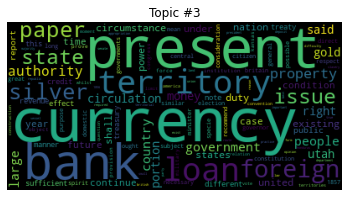

In [31]:
#topic 3 - wordcloud

plt.figure()
plt.imshow(WordCloud().fit_words(dict(lda_model_tuned.show_topic(3, 200))))
plt.axis("off")
plt.title("Topic #" + str(3))
plt.show()